# Running models individually for each house

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import time
import xgboost as xgb
from cuml.ensemble import RandomForestRegressor as cuRF
from scripts.function_utils import last_energy_points, build_predict_show, total_averaged_metrics_individual, show_graphic_per_timestep, build_predict_show_rf, show_all_metrics_per_house

In [2]:
data = pd.read_excel("~/datasets/Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


### Normalize data

In [3]:
values = df.values
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.060175,0.283908,0.248916,0.248916,0.248916,0.283908,0.077151,0.077151,0.119850,0.077151,...,0.283908,0.077151,0.077151,0.119850,0.283908,0.283908,0.077151,0.077151,0.283908,0.283908
1,0.052461,0.290083,0.248916,0.248916,0.248916,0.290083,0.062573,0.062573,0.119850,0.062573,...,0.290083,0.062573,0.062573,0.119850,0.290083,0.290083,0.062573,0.062573,0.290083,0.290083
2,0.062348,0.295667,0.212701,0.212701,0.212701,0.295667,0.124176,0.124176,0.126092,0.124176,...,0.295667,0.124176,0.124176,0.126092,0.295667,0.295667,0.124176,0.124176,0.295667,0.295667
3,0.054694,0.281326,0.212701,0.212701,0.212701,0.281326,0.143372,0.143372,0.126092,0.143372,...,0.281326,0.143372,0.143372,0.126092,0.281326,0.281326,0.143372,0.143372,0.281326,0.281326
4,0.052156,0.288978,0.147156,0.147156,0.147156,0.288978,0.062350,0.062350,0.223471,0.062350,...,0.288978,0.062350,0.062350,0.223471,0.288978,0.288978,0.062350,0.062350,0.288978,0.288978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,0.033783,0.274015,0.234634,0.234634,0.234634,0.274015,0.066700,0.066700,0.057428,0.066700,...,0.274015,0.066700,0.066700,0.057428,0.274015,0.274015,0.066700,0.066700,0.274015,0.274015
35132,0.033681,0.260312,0.193573,0.193573,0.193573,0.260312,0.065262,0.065262,0.022472,0.065262,...,0.260312,0.065262,0.065262,0.022472,0.260312,0.260312,0.065262,0.065262,0.260312,0.260312
35133,0.033783,0.267452,0.193573,0.193573,0.193573,0.267452,0.074137,0.074137,0.022472,0.074137,...,0.267452,0.074137,0.074137,0.022472,0.267452,0.267452,0.074137,0.074137,0.267452,0.267452
35134,0.034453,0.173039,0.041826,0.041826,0.041826,0.173039,0.061397,0.061397,0.023720,0.061397,...,0.173039,0.061397,0.061397,0.023720,0.173039,0.173039,0.061397,0.061397,0.173039,0.173039


### Preprocessing example

In [4]:
X,y = last_energy_points(df[0], 97)
print(X.shape, y.shape)
X

(35039, 97) (35039, 1)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97
0,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,2.599,2.344,...,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584,2.964
1,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,2.599,...,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584
2,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,...,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071
3,2.729,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,...,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694
4,2.368,2.729,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,...,2.514,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35034,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,1.668,1.675,...,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659,1.664,1.670
35035,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,1.668,...,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659,1.664
35036,1.659,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,...,1.664,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659
35037,1.664,1.659,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,...,1.663,1.664,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664


In [5]:
y

,Energy
0,2.677
1,3.522
2,2.729
3,2.368
4,2.642
...,...
35034,1.664
35035,1.659
35036,1.664
35037,1.697


## Test model

In [6]:
start_timestep = 97
number_timesteps = 97

## Linear Regression

In [7]:
model_lr, preds_lr, metrics_list_lr = [],[],[]
start_t = time.time()
for house in range(0,number_of_houses):
    print("\n House {}".format(house))
    mo_lr, p_lr, ml_lr = build_predict_show(pd.DataFrame(df[house]), number_timesteps, LinearRegression(), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_lr.append(mo_lr)
    preds_lr.append(p_lr)
    metrics_list_lr.append(ml_lr)
print("\nLinear Regression Elapsed time: %.3f seconds" % (time.time() - start_t))


 House 0

Number of features  97
RMSE: 0.4717
WAPE: 8.55
R2: 0.9077
RMSE: 0.3974
WAPE: 6.61
R2: 0.8923
RMSE: 0.3766
WAPE: 8.46
R2: 0.8407
RMSE: 0.3644
WAPE: 8.15
R2: 0.8648
RMSE: 0.3100
WAPE: 7.26
R2: 0.8547
RMSE: 0.3516
WAPE: 8.58
R2: 0.7812
RMSE: 0.3877
WAPE: 8.77
R2: 0.8721
RMSE: 0.3393
WAPE: 8.67
R2: 0.8911
RMSE: 1.7322
WAPE: 14.52
R2: 0.9749
RMSE: 0.3272
WAPE: 6.59
R2: 0.9515

Elapsed time: 0.112 seconds

Full Elapsed time: 0.112 seconds

 House 1

Number of features  97
RMSE: 0.5376
WAPE: 28.25
R2: 0.7822
RMSE: 0.5105
WAPE: 27.19
R2: 0.7615
RMSE: 0.4817
WAPE: 33.56
R2: 0.6574
RMSE: 0.4848
WAPE: 34.50
R2: 0.6507
RMSE: 0.4423
WAPE: 37.88
R2: 0.6217
RMSE: 0.4307
WAPE: 35.00
R2: 0.6797
RMSE: 0.4827
WAPE: 33.49
R2: 0.7043
RMSE: 0.5228
WAPE: 29.57
R2: 0.7143
RMSE: 0.5518
WAPE: 26.32
R2: 0.7408
RMSE: 0.6115
WAPE: 25.29
R2: 0.7258

Elapsed time: 0.054 seconds

Full Elapsed time: 0.054 seconds

 House 2

Number of features  97
RMSE: 0.3175
WAPE: 33.86
R2: 0.6314
RMSE: 0.2832
WAPE: 31.41


## XGBoost

In [9]:
model_xgb, preds_xgb, metrics_list_xgb = [],[],[]
start_t = time.time()
for house in range(0,number_of_houses):
    print("\n House {}".format(house))
    mo_xgb, p_xgb, ml_xgb = build_predict_show(pd.DataFrame(df[house]), number_timesteps, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, n_estimators=500), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_xgb.append(mo_xgb)
    preds_xgb.append(p_xgb)
    metrics_list_xgb.append(ml_xgb)
print("\nXGBoost Elapsed time: %.3f seconds" % (time.time() - start_t))


 House 0

Number of features  97
RMSE: 0.4959
WAPE: 8.64
R2: 0.8980
RMSE: 0.3873
WAPE: 6.48
R2: 0.8977
RMSE: 0.3516
WAPE: 7.70
R2: 0.8612
RMSE: 0.3330
WAPE: 7.14
R2: 0.8871
RMSE: 0.2925
WAPE: 6.70
R2: 0.8707
RMSE: 0.3383
WAPE: 7.92
R2: 0.7975
RMSE: 0.3649
WAPE: 7.85
R2: 0.8867
RMSE: 0.4134
WAPE: 9.44
R2: 0.8383
RMSE: 10.1926
WAPE: 56.71
R2: 0.1330
RMSE: 0.5556
WAPE: 13.62
R2: 0.8603

Elapsed time: 5.144 seconds

Full Elapsed time: 5.144 seconds

 House 1

Number of features  97
RMSE: 0.5409
WAPE: 28.06
R2: 0.7795
RMSE: 0.4938
WAPE: 25.43
R2: 0.7769
RMSE: 0.4855
WAPE: 35.31
R2: 0.6520
RMSE: 0.4808
WAPE: 33.99
R2: 0.6565
RMSE: 0.4331
WAPE: 36.84
R2: 0.6372
RMSE: 0.4194
WAPE: 34.04
R2: 0.6962
RMSE: 0.4699
WAPE: 31.85
R2: 0.7198
RMSE: 0.5093
WAPE: 27.66
R2: 0.7288
RMSE: 0.5386
WAPE: 24.94
R2: 0.7530
RMSE: 0.5991
WAPE: 24.78
R2: 0.7368

Elapsed time: 5.273 seconds

Full Elapsed time: 5.273 seconds

 House 2

Number of features  97
RMSE: 0.3496
WAPE: 37.38
R2: 0.5532
RMSE: 0.2403
WAPE: 26.6

## Random Forest

In [ ]:
model_rf, preds_rf, metrics_list_rf = [],[],[]
start_t = time.time()
for house in range(0,number_of_houses):
    print("\n House {}".format(house))
    mo_rf, p_rf, ml_rf = build_predict_show_rf(pd.DataFrame(df[house]), number_timesteps, cuRF(), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_rf.append(mo_rf)
    preds_rf.append(p_rf)
    metrics_list_rf.append(ml_rf)
print("\nRandom Forest Elapsed time: %.3f seconds" % (time.time() - start_t))

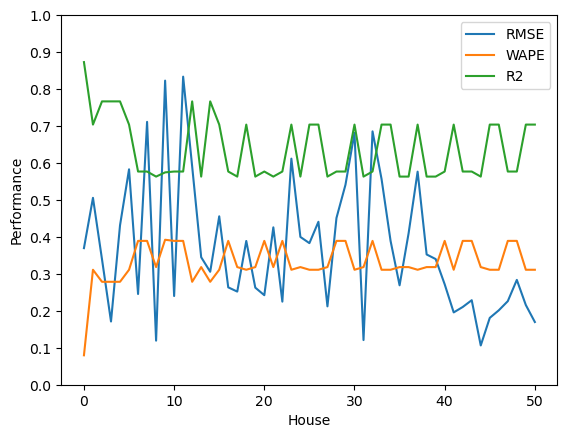

In [11]:
show_all_metrics_per_house(metrics_list_lr, number_of_houses)

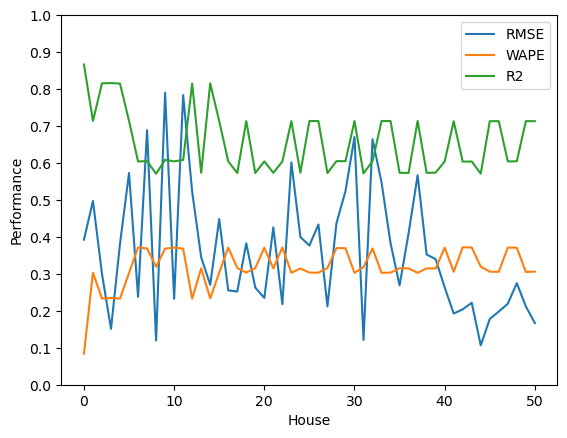

In [12]:
show_all_metrics_per_house(metrics_list_xgb, number_of_houses)

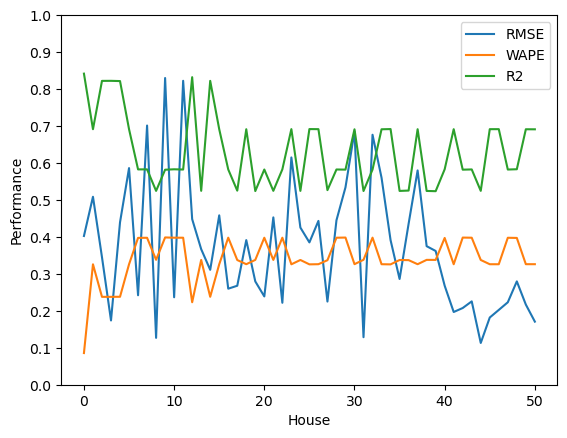

In [13]:
show_all_metrics_per_house(metrics_list_rf, number_of_houses)

### Total average

In [14]:
t_rmse_lr, t_wape_lr, t_r2_lr = total_averaged_metrics_individual(metrics_list_lr)

Total Averaged RMSE: 0.369
Total Averaged WAPE: 32.973
Total Averaged R2: 0.638


In [15]:
t_rmse, t_wape, t_r2 = total_averaged_metrics_individual(metrics_list_xgb)

Total Averaged RMSE: 0.359
Total Averaged WAPE: 31.657
Total Averaged R2: 0.656


In [16]:
t_rmse_rf, t_wape_rf, t_r2_rf = total_averaged_metrics_individual(metrics_list_rf)

Total Averaged RMSE: 0.372
Total Averaged WAPE: 33.779
Total Averaged R2: 0.631


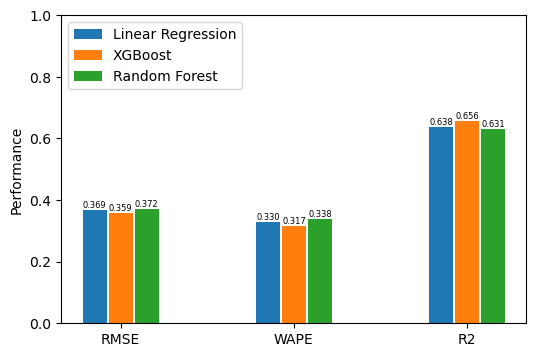

In [17]:
rmse = t_rmse_lr, t_rmse, t_rmse_rf
wape = t_wape_lr, t_wape, t_wape_rf
r2 = t_r2_lr, t_r2, t_r2_rf
model_names = ['Linear Regression', 'XGBoost', 'Random Forest']
X_names = ['RMSE', 'WAPE', 'R2']
X_axis = np.arange(len(X_names))
pos = 0
bar_width = 0.15
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(len(model_names)):
    bar = (rmse[i], wape[i]/100, r2[i])
    b = ax.bar(X_axis + pos, bar, bar_width-0.01, label=model_names[i])
    pos = pos + bar_width
    ax.bar_label(b, fontsize=6, fmt='%.3f')
    
ax.set_ylim(0,1)
ax.set_xticks(X_axis+bar_width,X_names)
ax.set_ylabel("Performance")
#ax.set_xlabel("Metrics")
#ax.set_title(title)
ax.legend(loc='upper left')
#plt.savefig(filename)
plt.show()